<a href="https://colab.research.google.com/github/Qureshihasaan/Search_Agent/blob/main/React_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install -q -U langchain langgraph langchain_community langchain_groq langsmith

In [39]:
import os
from google.colab import userdata

groq_api_key = userdata.get("groq_Api_Key")
langchain_api_key = userdata.get("LANGCHAIN_API_KEY")

os.environ["GROQ_API_KEY"] = groq_api_key
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "SEARCH_AGENT"

In [40]:
# Installing arxiv for research paper and wikipedia for searching as a tools.
!pip install arxiv wikipedia

In [41]:
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun


arxiv_wrapper = ArxivAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)




In [42]:
wikipedia_tool.invoke("who is babar azam")

'Page: Babar Azam\nSummary: Mohammad Babar Azam (Urdu, Punjabi: محمد بابر اعظم; pronounced [Muhamməd babəɾ azəm]; born 15 October 1994) is a Pakistani international cricketer and the former captain of the Pakistan national cricket team in all three formats of the game. A right-handed top-order batter,'

In [43]:
# It's define the research paper that is mention.
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [44]:
tools = [wikipedia_tool , arxiv_tool]

In [45]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages : Annotated[list, add_messages]

In [46]:
from langgraph.graph import StateGraph , START , END


builder = StateGraph(State)

In [47]:
from langchain_groq import ChatGroq

llm : ChatGroq = ChatGroq(
    model= "Gemma2-9b-It",
    api_key= groq_api_key,
)

In [48]:
llm_with_tools = llm.bind_tools(tools=tools)

In [49]:
def chatbot(state: State):
  return {"messages" : llm_with_tools.invoke(state["messages"])}

In [50]:
builder.add_node("Chatbot" , chatbot)

In [51]:
from langgraph.prebuilt import ToolNode , tools_condition

tool_node=ToolNode(tools=tools)
builder.add_node("tools" , tool_node)

In [52]:
builder.add_edge(START , "Chatbot")
builder.add_conditional_edges("Chatbot" , tools_condition)
builder.add_edge("tools" , "Chatbot")
# builder.add_edge("Chatbot" , END)

In [53]:
from langgraph.checkpoint.memory import MemorySaver

memory : MemorySaver = MemorySaver()

In [54]:
graph = builder.compile(checkpointer=memory)

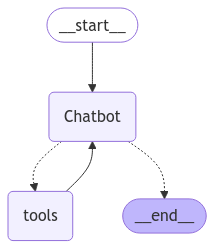

In [55]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# while True:
#   user_input = input("User: ")
#   if user_input.lower in ["quit" , "q" , "exit"]:
#     print("Good Bye!")
#     break
# for event in graph.stream({"messages" : ("User" , user_input)} , stream_mode='values'):
#   print(event.values)
#   for value in event.values:
#     print(value["messages"])
#     print("Assistant" , value["messages"].content)

User: what is 9/11
User: hello


KeyboardInterrupt: Interrupted by user

In [56]:
config = {"configurable": {"thread_id" : "1"}}

user_input = "what is AGI"

event =graph.stream(
    {"messages" : [("user" , user_input)]} , stream_mode='values' , config=config)
for value in event:
  value["messages"][-1].pretty_print()


================================ Human Message =================================

what is AGI
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_rfr5)
 Call ID: call_rfr5
  Args:
    query: Artificial general intelligence


================================= Tool Message =================================
Name: wikipedia

Page: Artificial general intelligence
Summary: Artificial general intelligence (AGI) is a type of artificial intelligence (AI) that matches or surpasses human cognitive capabilities across a wide range of cognitive tasks. This contrasts with narrow AI, which is limited to specific tasks. Artificial 
================================== Ai Message ==================================

AGI is a type of artificial intelligence that matches or surpasses human cognitive capabilities across a wide range of cognitive tasks. This contrasts with narrow AI, which is limited to specific tasks.


In [57]:
user_input = "hey! I am Hasaan"

event =graph.stream(
    {"messages" : [("user" , user_input)]} , stream_mode='values' , config=config)
for value in event:
  value["messages"][-1].pretty_print()

================================ Human Message =================================

hey! I am Hasaan
================================== Ai Message ==================================

Hello Hasaan, nice to meet you!


In [58]:
user_input = "what is my name"

event =graph.stream(
    {"messages" : [("user" , user_input)]} , stream_mode='values' , config=config)
for value in event:
  value["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

Your name is Hasaan.
